# Feature Importance with LIME

In [149]:
# Imports
from sklearn.datasets import load_digits, fetch_openml
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from skimage.segmentation import slic
from skimage.color import label2rgb, gray2rgb, rgb2gray
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from lime.lime_image import LimeImageExplainer
import cv2 as cv

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Step 0 -- Data Exploration & Preprocessing (copy)

In [5]:
# Adult dataset
data_adult = fetch_openml("adult", version=2, as_frame=True)
X_adult = data_adult.data
y_adult = data_adult.target
feature_subset = ['age', 'education-num', 'race', 'sex', 'hours-per-week']
X_adult = X_adult[feature_subset]
categorical_cols = X_adult.select_dtypes(include="category").columns
encoder = OrdinalEncoder()
X_adult = X_adult.copy()
X_adult.loc[:, categorical_cols] = encoder.fit_transform(X_adult[categorical_cols])

# Student performance dataset
data_students = fetch_ucirepo(id=320) 
X_students = data_students.data.features 
Y_students = data_students.data.targets 
Y_students_G3 = Y_students['G3'] # only the last, final grade (single-target)
X_students = pd.get_dummies(X_students) # one-hot encode categorical features
selected_features = ['failures', 'absences', 'goout', 'studytime', 'age'] # for visualization purposes, use only a subset of features
X_students_sub = X_students[selected_features]

# Digits dataset
data_digits = load_digits()
X_digits = data_digits.data
y_digits = data_digits.target

# Step 3 -- Feature Importance with LIME

LIME (Local Interpretable Model-agnostic Explanations) helps explain predictions of any classifier or regressor by approximating it **locally** with an interpretable model.

Key Ideas:
- LIME perturbs the input data around a specific instance and observes how the black-box model responds.
- It then fits a simple, interpretable model (e.g., linear regression) to this neighborhood.
- The coefficients of this simple model indicate which features influenced the prediction most for that instance.

Why LIME?
- Model-agnostic: works with any classifier or regressor.
- Offers **local** explanations that are easy to understand.
- Useful when you want to explain a single prediction rather than the model globally.

LIME vs. SHAP:
- Use LIME for quick, model-agnostic local explanations with simple interpretable output.
- Use SHAP when you need consistent, theoretically grounded explanations—especially for tree-based models with TreeExplainer, where it's both fast and accurate.

## Step 3.1 -- LIME for Tabular Data

#### Digits (as before -- tabular arrays)

In [7]:
# Training and evaluate a Random Forest model
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

# Model
clf_digits = RandomForestClassifier(random_state=42)
clf_digits.fit(X_train, y_train)

# Baseline
dummy_digits = DummyClassifier(strategy="most_frequent")
dummy_digits.fit(X_train, y_train)

# Evaluate
baseline_acc = accuracy_score(y_test, dummy_digits.predict(X_test))
model_acc = accuracy_score(y_test, clf_digits.predict(X_test))

print(f"Baseline accuracy: {baseline_acc:.3f}")
print(f"Random Forest accuracy: {model_acc:.3f}")

Baseline accuracy: 0.082
Random Forest accuracy: 0.971


In [22]:
# Create explainer
explainer = LimeTabularExplainer(X_train,
                                  mode="classification",
                                  training_labels=y_train,
                                  feature_names=[f"pixel {i}" for i in range(X_digits.shape[1])],
                                  discretize_continuous=True)

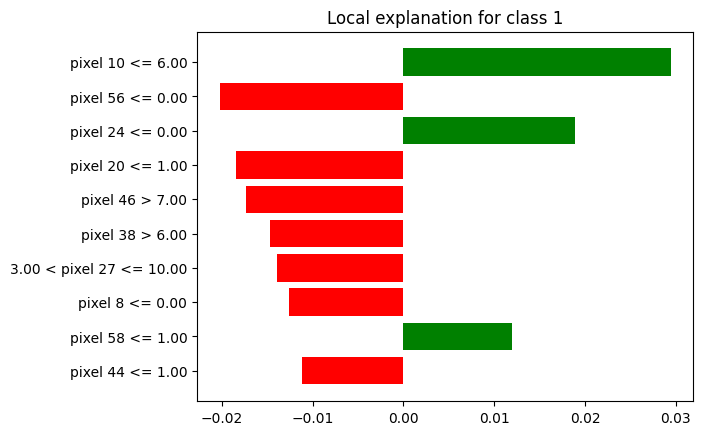

In [34]:
# Explain a specific test sample
i = 0  # sample index
exp = explainer.explain_instance(X_test[i], clf_digits.predict_proba, num_features=10)
exp.as_pyplot_figure()
plt.show()

### 🔍 LIME Explanations Are Class-Specific

By default, LIME explains the prediction for the **first class** only.

If you want to generate explanations for other classes (e.g., the highest-predicted class), you must pass the `top_labels` parameter to `explain_instance`:

In [46]:
# choose for how many classes (top _ classes) we need explanations
exp = explainer.explain_instance(X_test[i], 
                                 clf_digits.predict_proba, 
                                 num_features=10, 
                                 top_labels=5) # here

In [41]:
# check which labels are now available 
## note that it's an ordered list; the first one is the top predicted class
print("Available labels:", [int(label) for label in exp.available_labels()])

Available labels: [6, 8, 9, 4, 0]


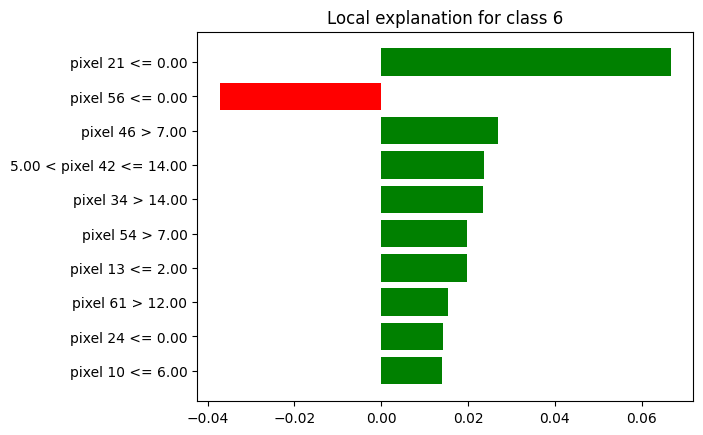

In [37]:
# choose for which class you want explanations
exp.as_pyplot_figure(label=6)  # choose with "label"
plt.show()

#### 📦 **LIME on Images as Tabular Data**
>
We've treated the digits dataset as **tabular data**, where each feature corresponds to a pixel (flattened 8×8 image).  
This allows us to use **LIME for tabular explanations**, but the results reference pixel indices rather than image locations.

To visualize which parts of the image LIME focuses on, we need to **map the pixel-level importances back into image space** (i.e., reshape the 64-dimensional feature vector back into an 8×8 grid).

In [50]:
# get explanations, but include all features now
exp = explainer.explain_instance(X_test[i], 
                                 clf_digits.predict_proba, 
                                 num_features=64, # here
                                 top_labels=5) 

# Extract weights for the predicted class
lime_dict = dict(exp.as_list(label=6))

In [98]:
# Problem: the explanations look like that
for item in list(lime_dict.items())[:3]:
    print(item)

('pixel 21 <= 0.00', 0.06569553999428986)
('pixel 48 <= 0.00', -0.03000262736719463)
('pixel 46 > 7.00', 0.02518679083391088)


In [53]:
# Parse pixel indices from strings like "pixel 21 <= 0.00"
import re
weights = np.zeros(64)

for key, value in lime_dict.items():
    match = re.search(r'pixel (\d+)', key)
    if match:
        idx = int(match.group(1))
        weights[idx] = value

In [55]:
# Now we have a list of importances for each pixel:
weights[:5]

array([ 0.        ,  0.00372537,  0.0130052 ,  0.0009326 , -0.00078181])

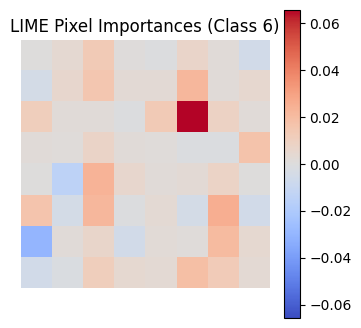

In [56]:
# Reshape and plot
plt.figure(figsize=(4, 4))
plt.imshow(weights.reshape(8, 8), cmap="coolwarm", vmin=-np.max(np.abs(weights)), vmax=np.max(np.abs(weights)))
plt.title("LIME Pixel Importances (Class 6)")
plt.axis("off")
plt.colorbar()
plt.show()

## Step 3.2 -- LIME for Image Data

In [75]:
# Rescale globally from [0, 16] → [0, 255] because LIME wants that
X_digits_rescaled = (X_digits / 16.0 * 255).astype(np.uint8)

# Reshape the flattened digits to 8x8 images
X_digits_img = X_digits_rescaled.reshape((-1, 8, 8))

# Convert 8x8 grayscale images to RGB because LIME wants that
X_digits_rgb = np.array([gray2rgb(img) for img in X_digits_img])

print(X_digits_img[0])

[[  0   0  79 207 143  15   0   0]
 [  0   0 207 239 159 239  79   0]
 [  0  47 239  31   0 175 127   0]
 [  0  63 191   0   0 127 127   0]
 [  0  79 127   0   0 143 127   0]
 [  0  63 175   0  15 191 111   0]
 [  0  31 223  79 159 191   0   0]
 [  0   0  95 207 159   0   0   0]]


In [76]:
# Train a model on flattened data (as required by sklearn)
## You could also train a neural network with PyTorch etc.
clf_digits = RandomForestClassifier(random_state=42)
clf_digits.fit(X_digits_rescaled, y_digits)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [77]:
# Define a wrapper around the RF predict_proba method: 
## convert RGB to grayscale and flatten, then use predict_proba
def rf_wrapper(imgs):
    grays = np.array([rgb2gray(img) for img in imgs])
    return clf_digits.predict_proba(grays.reshape((grays.shape[0], -1)))

In [78]:
# Pick one image to explain (2D image!)
i = 0
image = X_digits_img[i]

In [147]:
# LIME explanation
explainer = LimeImageExplainer(random_state=5)

# Segmentation function
## n_segments: controls the number of "superpixels" used to create areas
##   of similar pixels in the image. LIME will explain the influence of these
##   areas rather than stand-alone pixels (unless n_segments = the number of pixels)
## compactness: balances color similarity and spatial similarity to form superpixels
## start_label: superpixel labels will start from 0 (required by LIME)
segments_fn = lambda img: slic(img, 
                               n_segments=16, 
                               compactness=0.5, 
                               start_label=0)

# Obtaining explanations
## hide_color: superpixels that are "turned off" during perturbation are filled
##   with this value. These are irrelevant superpixels. Here: black
## num_samples: LIME creates many perturbed versions of the image to fit a local
##   surrogate model. Stability of results is expected to increase with higher
##   values here.
exp = explainer.explain_instance(
    X_digits_rgb[i],              # image to explain
    classifier_fn=rf_wrapper,     # model's prediction function
    top_labels=1,                 # top _ classes will be explained
    hide_color=0,                 
    num_samples=1000,
    segmentation_fn=segments_fn   # segmentation function
)

  0%|          | 0/1000 [00:00<?, ?it/s]

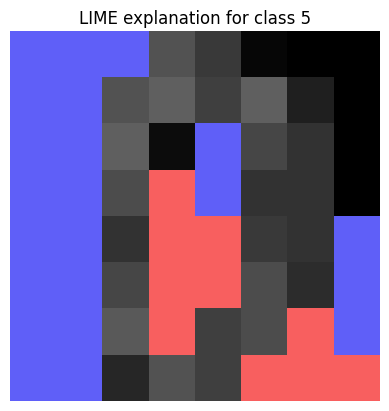

In [148]:
# Visualize
temp, mask = exp.get_image_and_mask(
    label=exp.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False
)
plt.imshow(label2rgb(mask, temp, bg_label=0, alpha=0.6))
plt.title(f"LIME explanation for class {exp.top_labels[0]}")
plt.axis("off")
plt.show()

<div style="border: 1px solid #ffcc00; background-color: #fff8e1; padding: 10px; border-radius: 5px; color: black;">
<b>🟡 Interpretation:</b> Understanding positive and negative contributions

This LIME explanation highlights both types of evidence the model used to classify the digit as a <b>5</b>:

- <b>Red regions</b>: positively contributed to the classification as a 5 — they support the prediction.
- <b>Blue regions</b>: negatively contributed — their presence made the model less confident in class 5.
- <b>Gray areas</b>: either neutral or not selected among the top 5 most influential regions.

This dual-color view gives a more nuanced picture of how the model balances supporting and opposing evidence when making predictions.
</div>


### ⚠️ LIME is Stochastic — Results May Vary

LIME generates explanations by fitting a local surrogate model to randomly perturbed versions of the input image.  
Because this sampling is **random**, the resulting explanation can **change** across runs — even for the same input image and class.

This is especially noticeable when:
- The number of perturbation samples (`num_samples`) is low,
- The underlying model has sharp decision boundaries,
- Or the input is near a class boundary.

✅ To make results reproducible, set `random_state`  
✅ To increase stability, use more samples (e.g., 3000+)

Below, we visualize five LIME runs for the same input and class, using different seeds:


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

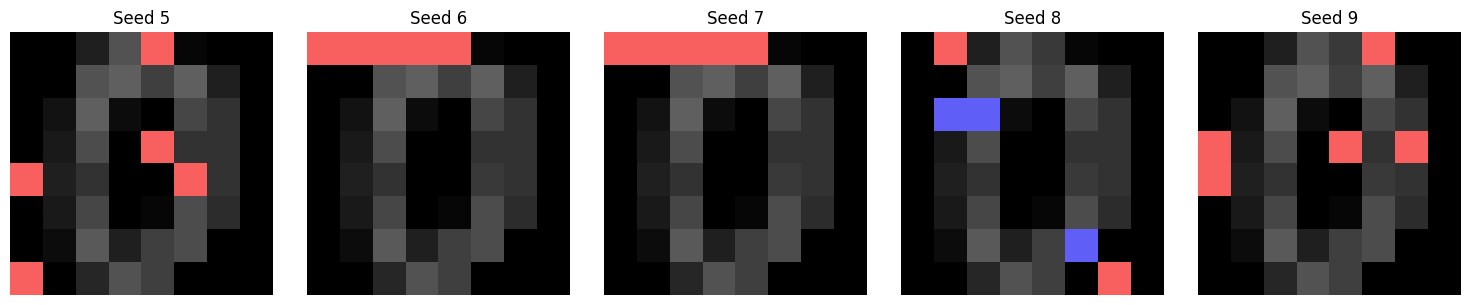

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
segments_fn = lambda img: slic(img, n_segments=32, compactness=0.5, start_label=0)

for ax, seed in zip(axes, [5, 6, 7, 8, 9]):
    explainer = LimeImageExplainer(random_state=seed) # different seeds here
    explanation = explainer.explain_instance(
        X_digits_rgb[i],
        classifier_fn=rf_wrapper,
        top_labels=1,
        hide_color=0,
        num_samples=1000,
        segmentation_fn=segments_fn
    )
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=False,
        num_features=5,
        hide_rest=False
    )
    ax.imshow(label2rgb(mask, temp, bg_label=0, alpha=0.6))
    ax.set_title(f"Seed {seed}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Step 2.4 -- Your turn!

<div style="border: 1px solid #ffcc00; background-color: #fff8e1; padding: 10px; border-radius: 5px; color: black;">
<b>🧠 Task:</b> Investigate how LIME explanations change with different settings.
</br>

Try modifying the following:
<ul>
  <li><code>n_segments</code>: how finely the image is segmented (e.g., 8, 16, 32, 64)</li>
  <li><code>compactness</code>: how regular or irregular the superpixel shapes are</li>
  <li><code>num_features</code>: how many superpixels to highlight in the final explanation</li>
  <li><code>hide_color</code>: what color to use for masked regions</li>
  <li><code>num_samples</code>: number of perturbations LIME uses to fit its local model</li>
</ul>

Observe:
<ul>
  <li>How do the explanations differ across settings?</li>
  <li>Are some explanations more plausible or stable than others?</li>
  <li>Would you trust this explanation if you had to make a decision based on it?</li>
</ul>

</div>

In [ ]:
# your code
...

<div style="border: 1px solid #ffcc00; background-color: #fff8e1; padding: 10px; border-radius: 5px; color: black;">
<b>🧠 Task (Optional):</b> Try LIME on a higher-resolution dataset with a pretrained neural network.
</br><br>

Suggestions:
<ul>
  <li>Load a pretrained <b>MobileNet</b> model using OpenCV's <code>dnn</code> module</li>
  <li>Download sample images from the web (e.g., animals, objects)</li>
  <li>Apply LIME to explain the top prediction</li>
</ul>

Does LIME still give intuitive explanations? What changes when you move from digits to natural images?
</div>


In [151]:
# download a pretrained model 

import urllib.request

# URLs to prototxt and caffemodel
prototxt_url = 'https://github.com/shicai/MobileNet-Caffe/raw/master/mobilenet_deploy.prototxt'
caffemodel_url = 'https://github.com/shicai/MobileNet-Caffe/raw/master/mobilenet.caffemodel'

# Download files
urllib.request.urlretrieve(prototxt_url, 'mobilenet_deploy.prototxt')
urllib.request.urlretrieve(caffemodel_url, 'mobilenet.caffemodel')

# Load the model
net = cv.dnn.readNetFromCaffe("mobilenet_deploy.prototxt", 
                              "mobilenet.caffemodel")

('mobilenet.caffemodel', <http.client.HTTPMessage at 0x19183a4e510>)

In [165]:
# Download a couple of images to play with (or use your own)

import urllib.request

# URLs of a few example images from ImageNet (raw images)
img_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/2/26/YellowLabradorLooking_new.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg"
]

# For loading images from URL
def preprocess_from_url(url):
    resp = urllib.request.urlopen(url)
    image_data = np.asarray(bytearray(resp.read()), dtype="uint8")
    img = cv.imdecode(image_data, cv.IMREAD_COLOR)
    return img

# For LIME's internal perturbed images
def preprocess_image(img):
    return cv.dnn.blobFromImage(
        img, scalefactor=1.0/127.5, size=(224, 224),
        mean=(127.5, 127.5, 127.5), swapRB=True, crop=False
    )

# Test images for you:
img1 = preprocess_from_url(img_urls[0])
img2 = preprocess_from_url(img_urls[1])

In [166]:
# Classifier wrapper for LIME
def mobilenet_wrapper(imgs):
    outputs = []
    for img in imgs:
        blob = preprocess_image(img)
        net.setInput(blob)
        out = net.forward()
        outputs.append(out.flatten())
    return np.vstack(outputs)

In [168]:
# LIME explainer and segmentation function
explainer = LimeImageExplainer(random_state=42)
segments_fn = lambda img: slic(img, n_segments=200, compactness=1, start_label=0)

In [171]:
# explain one of our images
explanation = explainer.explain_instance(img2, 
                                         classifier_fn=mobilenet_wrapper,
                                         top_labels=1,
                                         hide_color=0,
                                         num_samples=1000,
                                         segmentation_fn=segments_fn)

  0%|          | 0/1000 [00:00<?, ?it/s]

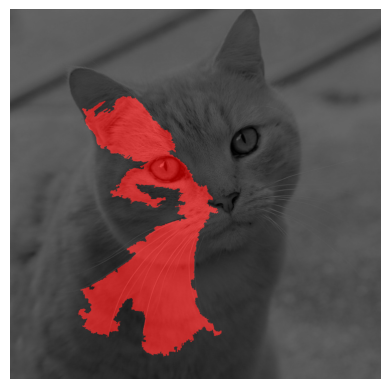

In [173]:
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0],
                                            positive_only=True,
                                            num_features=1, # explore this
                                            hide_rest=False)

plt.imshow(label2rgb(mask, temp, bg_label=0, alpha=0.6))
plt.axis("off")
plt.show()

<div style="border: 1px solid #ffcc00; background-color: #fff8e1; padding: 10px; border-radius: 5px; color: black;">
<b>💡 Insight:</b> One of the key advantages of <b>LIME</b> is that it is <b>model-agnostic</b> — it doesn't need to know anything about the internal structure of the model you're explaining.

<br>

In fact, in our example with MobileNet, <b>LIME has no idea</b> whether we're using a neural network, a random forest, or any other model. It simply queries the model via <code>predict_proba()</code> and builds a local approximation.


This makes LIME flexible and powerful — it can work with:
<ul>
  <li>Any black-box model</li>
  <li>High-dimensional feature spaces (e.g., images with thousands of pixels)</li>
  <li>Both classification and regression problems</li>
</ul>
</div>

<div style="border: 1px solid #007acc; background-color: #e6f2ff; padding: 10px; border-radius: 5px; color: black;">
<b>ℹ️ Want to explore more?</b><br>
Check out <a href="https://github.com/marcotcr/lime?tab=readme-ov-file" target="_blank">the LIME documentation</a> -- it contains lots of tutorials for different data types.
</div>